# Desafio Indicium - EDA

In [196]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re

from collections import Counter

## Data Overview

In [145]:
dados = pd.read_csv('teste_indicium_precificacao.csv')

In [146]:
dados.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


## Exploring the Data - Part 1 - Overview

### Sobre os tipos de dados

Temos dados de tipos variados:

* _strings_: nome, host_name, bairro_group, bairro, room_type, ultima_review (Date)
* _float_: latitude e longitude (GeoData), reviews_por_mes
* _int_: id, host_id, price, minimo_noites, numero_de_reviews, calculado_host_listings_count, disponibilidade_365

In [147]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

### Sobre os dados faltantes

* Existem alguns poucos dados faltantes em `nome` e `host_name`, 16 e 21 respectivamente, o que não é muito visto que corresponde a 0.0003% e 0.0004% dos dados.
* Muitos dados faltantes para `ultima_review` e `reviews_por_mes`, são 20% dos dados e são as mesmas entradas faltantes para as duas colunas.
* A remoção de todos os dados faltantes resultaria numa diminuição considerável na quantidade de dados (cerca de 20%), esse tratamento deve ser feito com muita cautela.


In [148]:
dados.isna().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64

In [149]:
dados[~dados['ultima_review'].isna()].isna().sum()

id                                0
nome                              6
host_id                           0
host_name                        16
bairro_group                      0
bairro                            0
latitude                          0
longitude                         0
room_type                         0
price                             0
minimo_noites                     0
numero_de_reviews                 0
ultima_review                     0
reviews_por_mes                   0
calculado_host_listings_count     0
disponibilidade_365               0
dtype: int64

In [150]:
dados.dropna().info()

<class 'pandas.core.frame.DataFrame'>
Index: 38820 entries, 0 to 48851
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             38820 non-null  int64  
 1   nome                           38820 non-null  object 
 2   host_id                        38820 non-null  int64  
 3   host_name                      38820 non-null  object 
 4   bairro_group                   38820 non-null  object 
 5   bairro                         38820 non-null  object 
 6   latitude                       38820 non-null  float64
 7   longitude                      38820 non-null  float64
 8   room_type                      38820 non-null  object 
 9   price                          38820 non-null  int64  
 10  minimo_noites                  38820 non-null  int64  
 11  numero_de_reviews              38820 non-null  int64  
 12  ultima_review                  38820 non-null  obje

## Exploring the Data - Part 2

### Sobre as Colunas

Primeiramente, vamos explorar cada coluna separadamente, analisando e criando gráficos das medidas estatísticas (quando for aplicável). Olhando somente para as colunas com tipo 'object' temos o seguinte:

* nome: string;
* host_name: string;
* bairro_group: categórica nominal;
* bairro: categórica nominal;
* room_type: categórica nominal;
* ultima_review: data;

Para as colunas com tipo 'number' temos o seguinte:

* id: numérica discreta (e única);
* host_id: numérica discreta;
* latitude: numérica contínua;
* longitude: numérica contínua;
* price: numérica discreta;
* minimo_noites: numérica discreta;
* numero_de_reviews: numérica discreta;
* reviews_por_mes: numérica discreta;
* calculado_host_listings_count: numérica discreta;
* disponibilidade_365: numérica discreta;


In [151]:
dados.select_dtypes(include='object').head()

,nome,host_name,bairro_group,bairro,room_type,ultima_review
0,Skylit Midtown Castle,Jennifer,Manhattan,Midtown,Entire home/apt,2019-05-21
1,THE VILLAGE OF HARLEM....NEW YORK !,Elisabeth,Manhattan,Harlem,Private room,NaN
2,Cozy Entire Floor of Brownstone,LisaRoxanne,Brooklyn,Clinton Hill,Entire home/apt,2019-07-05
3,Entire Apt: Spacious Studio/Loft by central park,Laura,Manhattan,East Harlem,Entire home/apt,2018-11-19
4,Large Cozy 1 BR Apartment In Midtown East,Chris,Manhattan,Murray Hill,Entire home/apt,2019-06-22


In [152]:
dados.select_dtypes(include='number').head()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,2845,40.75362,-73.98377,225,1,45,0.38,2,355
1,3647,4632,40.80902,-73.94190,150,3,0,NaN,1,365
2,3831,4869,40.68514,-73.95976,89,1,270,4.64,1,194
3,5022,7192,40.79851,-73.94399,80,10,9,0.10,1,0
4,5099,7322,40.74767,-73.97500,200,3,74,0.59,1,129


Ademais, podemos dizer que `ultima_review` e `calculado_host_listings_count` são colunas especiais, para elas adotaremos abordagens diferentes. Para a coluna `ultima_review` vamos converter o tipo para datetime, e, para simplificar, trabalharemos com a "quantidade de dias desde a última avaliação", com o 0 sendo a data mais recente.

In [153]:
dados['ultima_review'] = pd.to_datetime(dados['ultima_review'])

zero = dados['ultima_review'].max()

dados['ultima_review'] = ((zero - dados['ultima_review']).dt.days)

A coluna `calculado_host_listings_count` pode nos ajudar a identificar por exemplo a existência de pessoas físicas e empresas especializadas em aluguel de imóveis. Ao analisar as aparições únicas de cada `host_id` podemos perceber que a quantidade de hosts é menor do que a quantidade total de dados, o que pode ser um indicativo da existência de empresas especializadas.

In [154]:
dados_hosts = dados.drop_duplicates(subset='host_id', keep='first')
dados_hosts.shape

(37457, 16)

In [155]:
dados['calculado_host_listings_count'].value_counts()

calculado_host_listings_count
1      32303
2       6658
3       2853
4       1440
5        845
6        569
8        416
7        399
327      327
9        234
232      232
10       210
96       192
12       180
13       130
121      121
11       110
52       104
103      103
33        99
49        98
91        91
87        87
15        75
14        70
23        69
17        68
34        68
65        65
31        62
28        56
18        54
50        50
25        50
47        47
43        43
20        40
39        39
37        37
32        32
30        30
29        29
27        27
26        26
21        21
19        19
16        16
Name: count, dtype: int64

A partir da contagem feita acima podemos confirmar a hipótese. Com uma pesquisa nos dados e na internet, podemos verificar que existem pessoas jurídicas nos dados, como por exemplo as empresas "Sonder (NYC)"¹ e "Blueground"², além disso a maioria dos hosts anunciaram apenas uma vez, o que provavelmente são pessoas anunciando seus próprios imóveis. [Sonder](https://www.sonder.com/destinations/new_york_city/search?sleeps=1&neighborhood=all_neighborhoods&bedroom_count=0&bed_count=1&bathroom_count=1), [Blueground](https://www.theblueground.com)

In [156]:
dados[dados['calculado_host_listings_count'] == 327][['host_id','host_name']].iloc[0]

host_id         219517861
host_name    Sonder (NYC)
Name: 38292, dtype: object

In [157]:
dados[dados['calculado_host_listings_count'] == 232][['host_id','host_name']].iloc[0]

host_id       107434423
host_name    Blueground
Name: 26136, dtype: object

#### Categorical Variables

Sobre as variáveis categoricas é possível observar que há uma grande discrepância entre as quantidades em cada categoria, principalmente para a coluna `bairro`. A quantidade de anúncios para os 'bairros' de Manhattan e Brooklyn pode ser explicada pela grande densidade populacional¹, a  existência de muitos pontos turísticos² (Times Square, Central Park, Empire State, Wall Street, Broadway e a Brooklyn Bridge), e além disso existe grande concentração de complexos habitacionais com considerável taxa de desocupação³. A predominância de prédios pode explicar os números para 'Entire home/apt' e 'Private room' em 'room_type'. [1](https://pt.wikipedia.org/wiki/Brooklyn#Demografia:~:text=%C3%A9%20de%208%2C3%25.-,Censo%202020,desocupadas.%20A%20m%C3%A9dia%20de%20ocupa%C3%A7%C3%A3o%20%C3%A9%20de%202%2C5%20pessoas%20por%20resid%C3%AAncia.,-Estimativa%202018) [2](https://pt.wikipedia.org/wiki/Manhattan#Censo_2020:~:text=%5B25%5D-,Caracter%C3%ADsticas,pontos%20tur%C3%ADsticos%20americanos%20mais%20conhecidos%20e%20visitados%20dos%20Estados%20Unidos.,-Organiza%C3%A7%C3%A3o) [3](https://pt.wikipedia.org/wiki/Brooklyn#Demografia:~:text=Deste%20total%2C%206%2C3%25%20das%20unidades%20habitacionais%20est%C3%A3o%20desocupadas)

In [158]:
dados['bairro_group'].value_counts()

bairro_group
Manhattan        21661
Brooklyn         20103
Queens            5666
Bronx             1091
Staten Island      373
Name: count, dtype: int64

In [159]:
dados['bairro'].value_counts()

bairro
Williamsburg          3920
Bedford-Stuyvesant    3714
Harlem                2658
Bushwick              2465
Upper West Side       1971
                      ... 
Richmondtown             1
Fort Wadsworth           1
New Dorp                 1
Rossville                1
Willowbrook              1
Name: count, Length: 221, dtype: int64

In [160]:
dados['room_type'].value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

#### Numerical Variables

Nas variáveis numéricas podemos observar uma grande quantidade de outliers, inclusive para a variável alvo (`price`), isso pode acontecer por erros na coleta dos dados, ou simplesmente pelo tipo de imóvel que está sendo anunciado, espaço maior ou localização privilegiada são fatores que podem adicionar discrepância nos preços. Olhando para a variável `disponibilidade_365`, podemos perceber que os anúncios estão disponíveis para reserva uma boa parte do ano, e também variável `numero_de_reviews` contém muitos outliers, que podem indicar anúncios de lugares com muitas visitas. 

Text(0.5, 1.0, 'Boxplot price sem outliers')

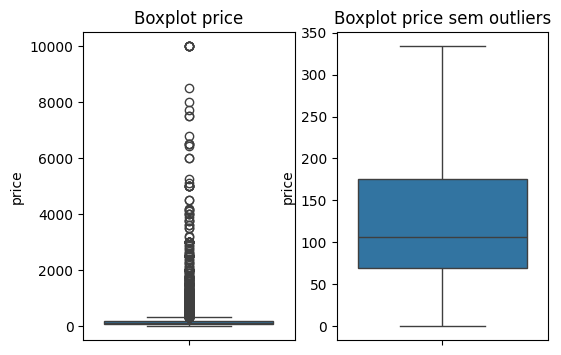

In [161]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
sns.boxplot(data=dados, y='price', ax=ax[0])
sns.boxplot(data=dados, y='price', showfliers=False, ax=ax[1])

ax[0].set_title(f'Boxplot price')
ax[1].set_title(f'Boxplot price sem outliers')

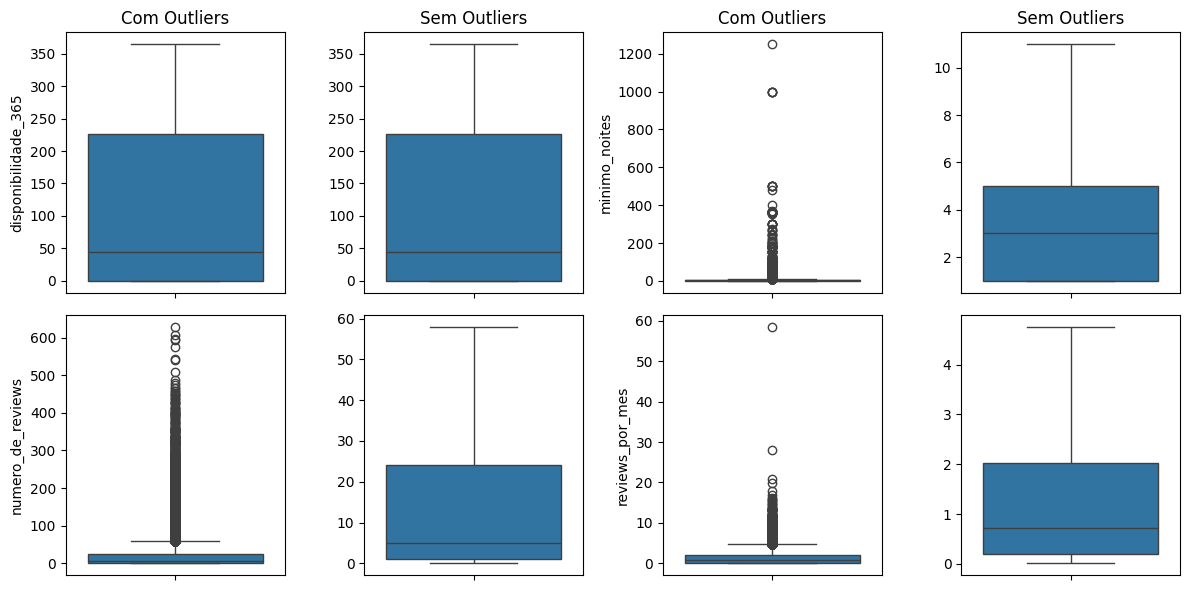

In [162]:
fig, ax = plt.subplots(2, 4, figsize=(12, 6))  # Ajuste do tamanho

# Gráficos com e sem outliers
sns.boxplot(data=dados, y='disponibilidade_365', ax=ax[0, 0])
ax[0, 0].set_ylabel("disponibilidade_365")  # Nome da variável à esquerda
ax[0, 0].set_title("Com Outliers")  # Título

sns.boxplot(data=dados, y='disponibilidade_365', showfliers=False, ax=ax[0, 1])
ax[0, 1].set_ylabel("")
ax[0, 1].set_title("Sem Outliers")

sns.boxplot(data=dados, y='minimo_noites', ax=ax[0, 2])
ax[0, 2].set_ylabel("minimo_noites")
ax[0, 2].set_title("Com Outliers")

sns.boxplot(data=dados, y='minimo_noites', showfliers=False, ax=ax[0, 3])
ax[0, 3].set_ylabel("")
ax[0, 3].set_title("Sem Outliers")

sns.boxplot(data=dados, y='numero_de_reviews', ax=ax[1, 0])
ax[1, 0].set_ylabel("numero_de_reviews")

sns.boxplot(data=dados, y='numero_de_reviews', showfliers=False, ax=ax[1, 1])
ax[1, 1].set_ylabel("")

sns.boxplot(data=dados, y='reviews_por_mes', ax=ax[1, 2])
ax[1, 2].set_ylabel("reviews_por_mes")

sns.boxplot(data=dados, y='reviews_por_mes', showfliers=False, ax=ax[1, 3])
ax[1, 3].set_ylabel("")

# Ajustar layout
plt.tight_layout()
plt.show()


Text(0.5, 1.0, 'Boxplot ultima_review sem outliers')

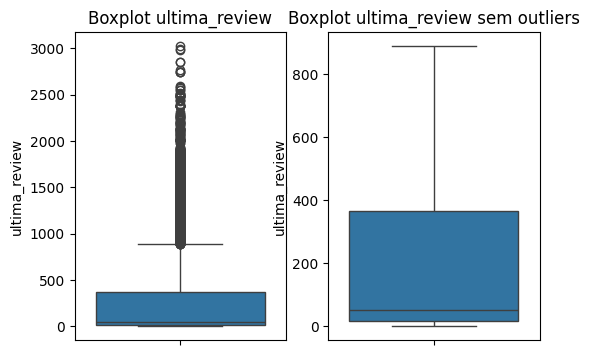

In [163]:
fig, ax = plt.subplots(1, 2, figsize=(6, 4))
sns.boxplot(data=dados, y='ultima_review', ax=ax[0])
sns.boxplot(data=dados, y='ultima_review', showfliers=False, ax=ax[1])

ax[0].set_title(f'Boxplot ultima_review')
ax[1].set_title(f'Boxplot ultima_review sem outliers')

## Exploring the Data - Part 3

Nesta seção, exploraremos as relações entre variáveis (colunas), criando visualizações que nos ajudem a obter informações importantes sobre os dados. Primeiramente, vamos tentar entender as relações entre a variável alvo (`price`) e as demais variáveis. 

A partir dos gráficos, acerca de `price`, podemos tirar as seguintes conclusões:

* O distrito de Manhattan detém os maiores preços nos anúncios, enquanto o Bronx os menores;
* Além de 'Entire home/apt' serem o tipo de quarto com maior frequência, é também o que com maiores preços;
* Os valores dos anúncios variam muito, mas com relação a latitude e longitude, fica claro que a maior concentração de preços altos está na área que corresponde a Manhattan, confirmando a informação acima;

Text(0.5, 1.0, 'Price variation of bairro_group without outliers')

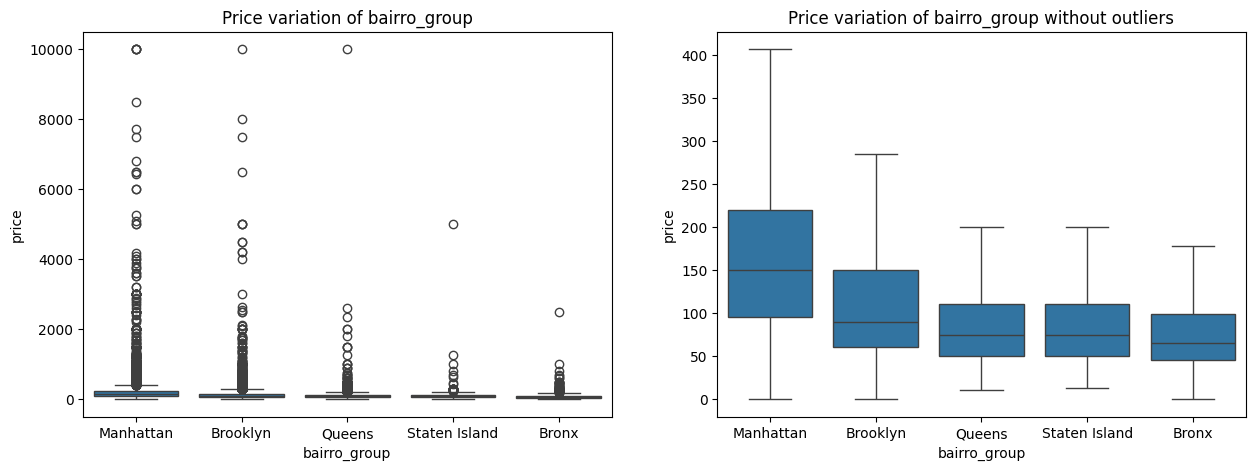

In [164]:
var = 'bairro_group'

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=dados, x=var, y='price', ax=axes[0])
sns.boxplot(data=dados, x=var, y='price', showfliers=False, ax=axes[1])

axes[0].set_title(f'Price variation of {var}')
axes[1].set_title(f'Price variation of {var} without outliers')

Text(0.5, 1.0, 'Price variation of room_type without outliers')

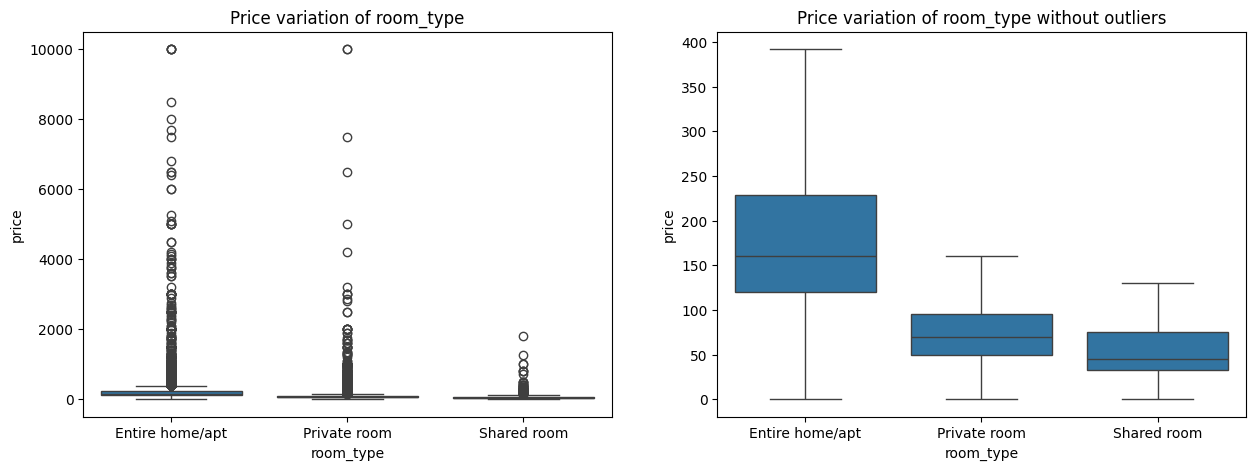

In [165]:
var = 'room_type'

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.boxplot(data=dados, x=var, y='price', ax=axes[0])
sns.boxplot(data=dados, x=var, y='price', showfliers=False, ax=axes[1])

axes[0].set_title(f'Price variation of {var}')
axes[1].set_title(f'Price variation of {var} without outliers')

<Axes: xlabel='longitude', ylabel='latitude'>

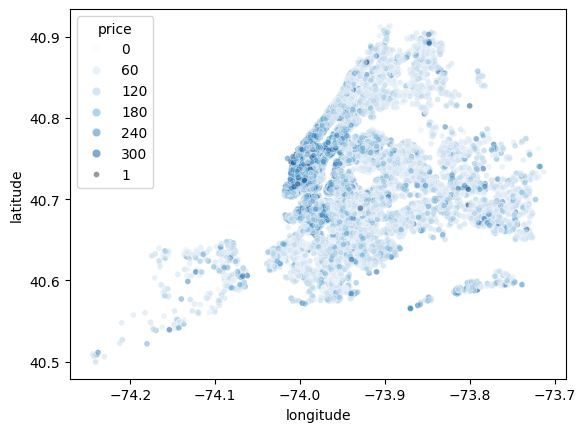

In [166]:
# Filtrando os outliers para melhor visualização
sns.scatterplot(data=dados[dados['price'] < 350], y='latitude', x='longitude', hue='price', size=1, alpha=0.5, palette='Blues')

Agora vamos passar a analisar as relações entre as variáveis não-alvo.

* Sobre a distribuição dos tipos de quarto, podemos dizer que está bem homogênia em toda a área da cidade, considerando que 'Shared room' tem muito menos dados do que 'Entire home/apt' e 'Private room'
* 'Entire home/apt' e apartamentos apresentam uma quantidade maior no número mínimo de noites para reservar quando comparados a 'Private room' e 'Shared room'
* 'Private room' apresenta número de avaliações ligeiramente maior do que os outros tipos de quarto
* 'Staten Island' demonstra número de avaliações estatísticamente maior do que os outros distritos, e em 'Manhattan' o número mínimo de noites para reserva é um pouco maior do que nos outros;

Text(0.5, 0.98, 'room_type distribution')

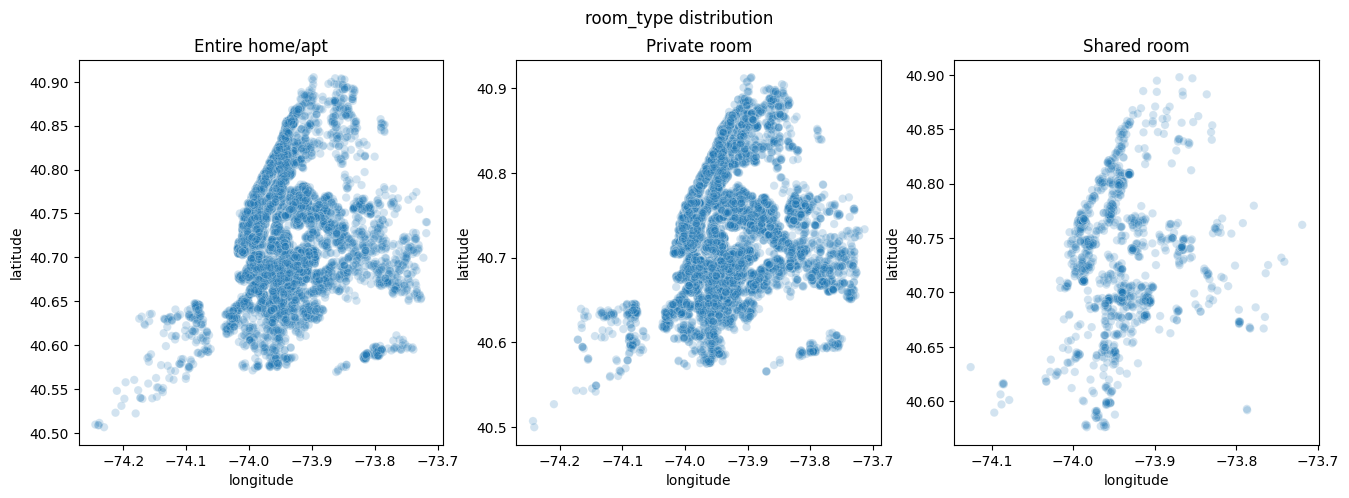

In [167]:
fig, ax = plt.subplots(1,3,figsize=(16, 5))

sns.scatterplot(data=dados[dados['room_type'] == 'Entire home/apt'], y='latitude', x='longitude', hue='room_type', alpha=0.2, ax=ax[0], legend=False)
sns.scatterplot(data=dados[dados['room_type'] == 'Private room'], y='latitude', x='longitude', hue='room_type', alpha=0.2, ax=ax[1], legend=False)
sns.scatterplot(data=dados[dados['room_type'] == 'Shared room'], y='latitude', x='longitude', hue='room_type', alpha=0.2, ax=ax[2], legend=False)

ax[0].set_title('Entire home/apt')
ax[1].set_title('Private room')
ax[2].set_title('Shared room')

fig.suptitle('room_type distribution')

Text(0.5, 1.0, 'room_type x numero_de_reviews *without outliers')

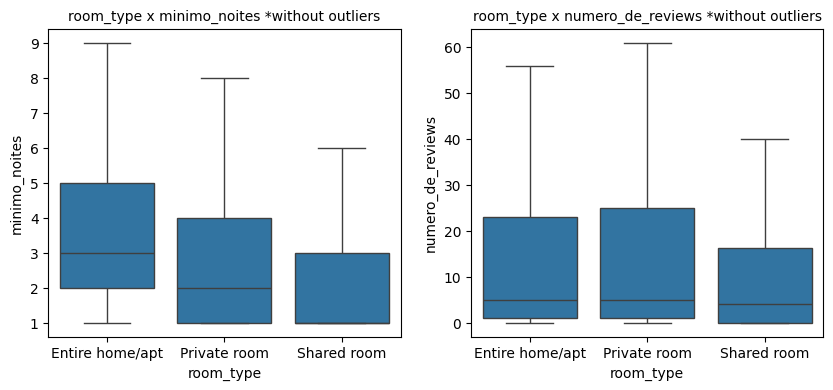

In [168]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

sns.boxplot(data=dados, x='room_type', y='minimo_noites', showfliers=False, ax=axes[0])
sns.boxplot(data=dados, x='room_type', y='numero_de_reviews', showfliers=False, ax=axes[1])

axes[0].set_title(f'room_type x minimo_noites *without outliers', fontsize=10)
axes[1].set_title(f'room_type x numero_de_reviews *without outliers', fontsize=10)

Text(0.5, 1.0, 'bairro_group x numero_de_reviews *without outliers')

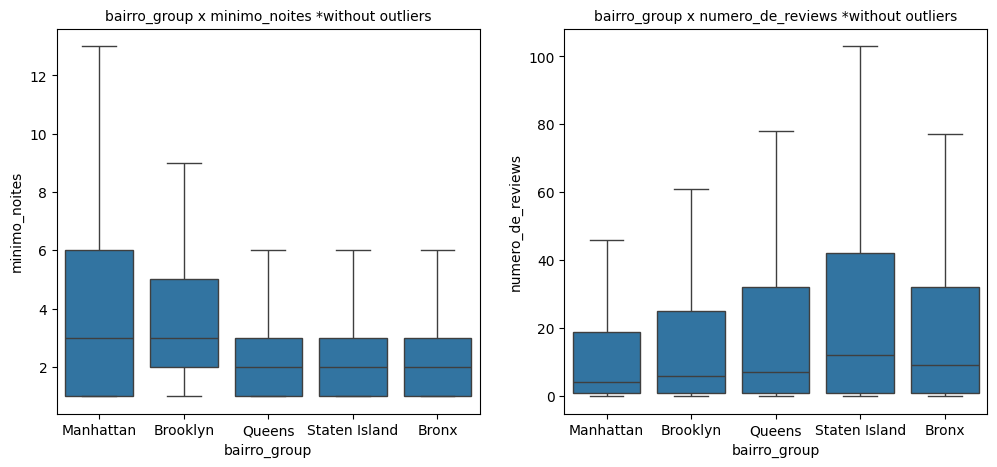

In [169]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.boxplot(data=dados, x='bairro_group', y='minimo_noites', showfliers=False, ax=axes[0])
sns.boxplot(data=dados, x='bairro_group', y='numero_de_reviews', showfliers=False, ax=axes[1])

axes[0].set_title(f'bairro_group x minimo_noites *without outliers', fontsize=10)
axes[1].set_title(f'bairro_group x numero_de_reviews *without outliers', fontsize=10)

## Respondendo as Questões:

1. Supondo que uma pessoa esteja pensando em investir em um apartamento para alugar na plataforma, onde seria mais indicada a compra?

Esta é uma pergunta difícil porque muitos fatores devem ser considerados. Vamos começar por onde uma pessoa não deveria investir:

* Staten Island:

    * [É o distrito menos populoso](https://en.wikipedia.org/wiki/Staten_Island#:~:text=Staten%20Island%20%C3%A9%20o%20distrito%20menos%20populoso%20da%20cidade%20de%20Nova%20York);
    * [É o distrito mais suburbando da cidade](https://en.wikipedia.org/wiki/Staten_Island#:~:text=%C3%A9%20tamb%C3%A9m%20o%20distrito%20menos%20densamente%20povoado%20e%20mais%20suburbano%20da%20cidade.);
    * [Não é conectado ao sistema de metrô de Nova Iorque](https://en.wikipedia.org/wiki/Staten_Island#:~:text=Staten%20Island%20%C3%A9%20o%20%C3%BAnico%20bairro%20n%C3%A3o%20conectado%20ao%20sistema%20de%20metr%C3%B4%20da%20cidade%20de%20Nova%20York%20.);
    * Longe das grandes atrações turísticas;

* Bronx:

    * [É um distrito predominantemente residensial](https://pt.wikipedia.org/wiki/Nova_Iorque#Composi%C3%A7%C3%A3o_%C3%A9tnica_e_imigrantes:~:text=Bronx%20%C3%A9%20um%20distrito%20predominantemente%20residencial);
    * [É o distrido mais pobre e violento da cidade de Nova Iorque](https://pt.wikipedia.org/wiki/Nova_Iorque#Composi%C3%A7%C3%A3o_%C3%A9tnica_e_imigrantes:~:text=%C3%89%20atualmente%20o%20distrito%20mais%20pobre%20e%20violento%20da%20cidade%2C%20bem%20como%20um%20dos%20condados%20mais%20pobres%20e%20violentos%20do%20pa%C3%ADs.%5B185%5D);

* Brooklyn:

    * [Densidade populacional alta](https://en.wikipedia.org/wiki/Brooklyn#:~:text=Brooklyn%2C%20com%2037.339%2C9,%5B%207%20%5D);
    * [Altas taxas de criminalidade](https://www.tsiglerlaw.com/blog/brooklyn-crime-rate/#:~:text=The%20overall%20serious%20crime%20rate,of%209%20per%201%2C000%20residents.)


Como opções viáveis restaram Manhattan e Queens:

* Manhattan:
    * Prós: 
        * [Lar dos pontos turísticos mais conhecidos de Nova Iorque](https://en.wikipedia.org/wiki/Manhattan#Tourism:~:text=O%20turismo%20%C3%A9,%5B%20228%20%5D);
        * [Economia: Centro econômico da cidade, maior renda per capta dos EUA](https://en.wikipedia.org/wiki/Manhattan#Economy:~:text=Manhattan%20%C3%A9%20o%20motor%20econ%C3%B4mico%20da%20cidade%20de%20Nova%20York);
        * [Alta do setor de tecnologia](https://en.wikipedia.org/wiki/Manhattan#Tech_and_biotech:~:text=Manhattan%20impulsionou%20o,em%20seu%20escopo.);
        * [Reconhecidamente o setor imobiliário é um dos pilares da economia de Manhattan](https://en.wikipedia.org/wiki/Manhattan#Real_estate:~:text=O%20mercado%20imobili%C3%A1rio,em%20Midtown%20Manhattan.).
    * Contras:
        * Como vimos nas análises, os preços são altíssimos;
        * Concorrência: o mercado imobiliário já está bem estabelecido;

* Queens:
    * Prós:
        * Proximidade com o aeroporto da cidade;
        * Em área, é o maior dos cinco distritos;
        * Recebe muitos estrangeiros, que são quase metade da população total;
        * Economia diversificada, a 2ª maior depois de Manhattan;

No fim, o Queens parece um bom lugar para fazer esse investimento, ainda existem áreas não totalmente exploradas que podem ser interessantes.

2. O número mínimo de noites e a disponibilidade ao longo do ano interferem no preço?

A princípio não, o número de noites e a disponibilidade ao longo do ano apresentam coeficientes de correlação muito baixo para afirmar que eles interferem no preço.

Vamos analisar os dados para identificar se as variáveis `minimo_noites` e `disponibilidade_365` interferem no preço. Primeiramente, vamos observar o comportamento das duas variáveis em relação ao preço, para tal vamos utilizar como ferramenta o gráfico de dispersão.

Text(0.5, 1.0, 'Relação entre Preço e Disponibilidade ao longo do Ano')

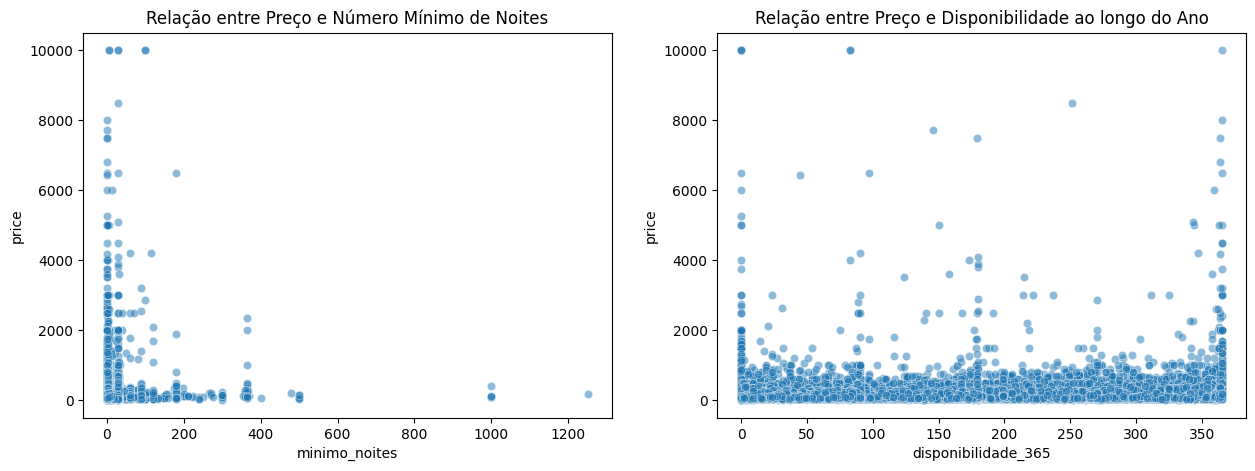

In [170]:
fig, axes = plt.subplots(1,2,figsize=(15,5))

sns.scatterplot(data=dados, x='minimo_noites', y='price', alpha=0.5, ax=axes[0])
sns.scatterplot(data=dados, x='disponibilidade_365', y='price', alpha=0.5, ax=axes[1])

axes[0].set_title("Relação entre Preço e Número Mínimo de Noites")
axes[1].set_title("Relação entre Preço e Disponibilidade ao longo do Ano")

Ao observar os gráficos acima não é possível identificar com clareza alguma relação das variáveis `minimo_noites` e `disponibilidade_365` com a variável `price`. Como segundo passo, vamos analisar a matriz de correlação, utilizando o método de pearson, a correlação nos ajuda a entender se há alguma dependência ou relação estatística entre as variáveis. Um detalhe para a correlação de pearson é que esta medida é muito sensível a outliers, então precisamos removê-los para fazer o teste. Para a remoção, vamos utilizar o [Método de Tukey](https://medium.com/@lucapqg/como-detectar-e-tratar-outliers-com-python-ca2cf088c160#:~:text=M%C3%A9todo%20de%20Tukey,%F0%9D%90%BF%F0%9D%91%A0%F0%9D%91%A2%F0%9D%91%9D%20%3D%20%F0%9D%91%843%20%2B%20(1.5%20%E2%88%97%20%F0%9D%90%BC%F0%9D%91%84%F0%9D%91%85)), consiste em definir os limites inferior e superior a partir do interquartil (IQR) e dos primeiros (Q1) e terceiros (Q3) quartis.

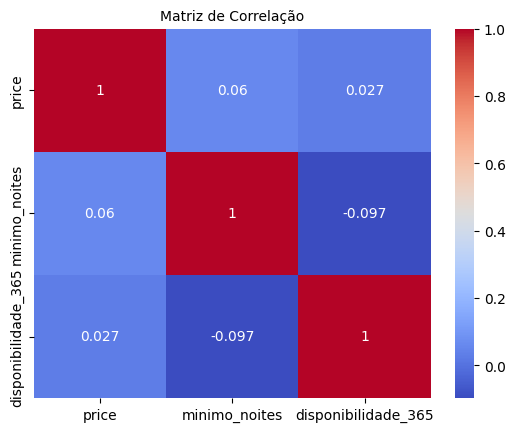

In [171]:
df = dados[['price', 'minimo_noites','disponibilidade_365']].copy()

q1_p, q3_p = df['price'].quantile(0.25), df['price'].quantile(0.75)
inf_p, sup_p = q1_p - ((q3_p - q1_p)*1.5), q3_p + ((q3_p - q1_p)*1.5)

q1_m, q3_m = df['minimo_noites'].quantile(0.25), df['minimo_noites'].quantile(0.75)
inf_m, sup_m = q1_m - ((q3_m - q1_m)*1.5), q3_m + ((q3_m - q1_m)*1.5)

df = df[(df['price'] >= inf_p) & (df['price'] <= sup_p) & (df['minimo_noites'] >= inf_m) & (df['minimo_noites'] <= sup_m)]

correlation_matrix = df[['price', 'minimo_noites','disponibilidade_365']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm")
plt.title("Matriz de Correlação", fontsize=10)
plt.show()

Segundo a matriz de correlação, as variáveis não demonstraram importância estatisticamente significativa no preço. Para finalizar vamos fazer um teste de regressão linear utilizando a biblioteca statsmodels, o teste poderá nos dizer o quanto é possível determinar o preço a partir de `minimo_noites` e `disponibilidade_365`.

In [172]:
import statsmodels.api as sm

X = df[['minimo_noites', 'disponibilidade_365']]
X = sm.add_constant(X)
y = df['price']

# Regressão linear
model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     93.51
Date:                Sat, 25 Jan 2025   Prob (F-statistic):           3.06e-41
Time:                        13:36:37   Log-Likelihood:            -2.2348e+05
No. Observations:               39737   AIC:                         4.470e+05
Df Residuals:                   39734   BIC:                         4.470e+05
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                 111.1165    

A partir dos resultados podemos dizer que as variáveis `minimo_noites` e `disponibilidade_365` interferem muito pouco no preço, tendo em vista que o valor 'R-squared' é muito pequeno (0.005), o que significa que apenas 0.5% da variação em price é explicada pelos preditores, e o mesmo vale para o 'Adj. R-squared'.

3. Existe algum padrão no texto do nome do local para lugares de mais alto valor?

Primeiramente precisamos encontrar quais são os lugares com mais alto valor, vamos utilizar para isso as colunas `bairro_group` e `room_type`:

In [216]:
df = dados.copy()

q1_p, q3_p = df['price'].quantile(0.25), df['price'].quantile(0.75)
inf_p, sup_p = q1_p - ((q3_p - q1_p)*1.5), q3_p + ((q3_p - q1_p)*1.5)

df = df[(df['price'] >= inf_p) & (df['price'] <= sup_p)]

In [217]:
price_bairro_room = df.pivot_table(values='price', index='bairro_group', columns='room_type', aggfunc='mean')
price_bairro_room

room_type,Entire home/apt,Private room,Shared room
bairro_group,,,
Bronx,112.195592,60.595679,47.254237
Brooklyn,148.202080,70.275619,48.036496
Manhattan,181.688596,98.057700,75.939785
Queens,131.328388,65.732319,46.989691
Staten Island,121.089286,62.292553,57.444444


A partir da tabela acima podemos perceber que os aluguéis mais caros são de casas e apartamentos em Manhattan. Com essa informação, vamos filtrar os dados de nomes procurando padrões nos títulos dos anúncios.

In [218]:
dados_filtered = df[(df['bairro_group'] == 'Manhattan') & (df['room_type'] == 'Entire home/apt')].copy()
dados_filtered['nome'] = dados_filtered['nome'].astype(str)
dados_filtered.head(2)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,48.0,0.38,2,355
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,231.0,0.10,1,0


Para procurar os padrões será usada a seguinte estratégia:

* Transformar todas as palavras em minúsculas
* Em cada entrada da coluna `nome`, serão retiradas: pontuações, stop words e números
* Retornar uma lista só com as palavras selecionadas em cada entrada da coluna
* Fazer a contagem das palavras e retornar as 50 mais frequentes

In [219]:
ad_names = dados_filtered['nome'].apply(lambda x: re.findall(r'\b\w{4,}\b', str(x).lower()))
ad_names = np.concatenate(ad_names.values).tolist()
words = dict(Counter(ad_names).most_common(50))
words

{'studio': 2447,
 'apartment': 2091,
 'bedroom': 1875,
 'east': 1759,
 'village': 1462,
 'cozy': 997,
 'west': 988,
 'park': 884,
 'spacious': 877,
 'manhattan': 872,
 'side': 829,
 'central': 826,
 'upper': 774,
 'heart': 662,
 'midtown': 658,
 'luxury': 587,
 'beautiful': 578,
 'location': 578,
 'near': 557,
 'sunny': 531,
 'with': 520,
 'harlem': 496,
 'square': 495,
 'modern': 494,
 'charming': 487,
 'large': 486,
 'chelsea': 483,
 'private': 428,
 'bright': 398,
 'sonder': 361,
 'loft': 354,
 'quiet': 338,
 'times': 337,
 'doorman': 317,
 'great': 306,
 'soho': 306,
 'amazing': 271,
 'home': 268,
 'prime': 254,
 'from': 244,
 'lower': 229,
 'clean': 225,
 'kitchen': 218,
 'best': 213,
 'entire': 192,
 'renovated': 189,
 'perfect': 187,
 'views': 186,
 'view': 178,
 'blueground': 178}

Ao analisar as palavras mais frequentes, podemos perceber que existem palavras mais padronizadas para anúncios como: studio, bedroom, apartment, village, etc. Além dessas, ainda há palavras que descrevem características do padrão de vida do lugar: luxury, spacious, modern, private, bright, beautiful, amazing, prime, etc. Podemos selecionar algumas dessas palavras e criar uma tabela de contingência com o preço médio dos anúncios em que essas palavras aparecem ou não.

In [226]:
new_words = ['luxury','spacious','modern','private','bright','beautiful','amazing','prime','views','view']
has, no_has = [], []

for word in new_words:
    has.append(dados_filtered[dados_filtered['nome'].str.contains(word, case=False, na=False)]['price'].mean())
    no_has.append(dados_filtered[~dados_filtered['nome'].str.contains(word, case=False, na=False)]['price'].mean())

has = np.array(has)
no_has = np.array(no_has)

In [227]:
table = pd.DataFrame([has, no_has], columns=new_words, index=['has', 'no_has'])
table

,luxury,spacious,modern,private,bright,beautiful,amazing,prime,views,view
has,213.443124,182.590650,189.631263,176.599537,186.822055,178.128425,191.765343,194.417323,219.082474,207.984293
no_has,179.941429,181.612652,181.321445,181.890996,181.500597,181.882726,181.435236,181.395743,181.035045,180.768054
